# Programmatic Visualization

### 3D plotting of atomic coordinates

Colin Ophus (cophus@gmail.com) - 2024 Dec 30

This tutorial demonstrates how we can create a fancy 3D scatter plot of atomic coordinates.

Packages used:

- numpy (handle numerical arrays)
- matplotlib (most common python plotting library)
- h5py (read and write hdf5 files)
- tqdm (progress bar)
- gdown (download files)

Atomic coordinates are taken from this paper:

[Observing crystal nucleation in four dimensions using atomic electron tomography](https://doi.org/10.1038/nature21042)


Also a few important notes - in matplotlib, the x and y axes ARE FLIPPED compared to the array indexing notation (i.e. row, column, page, etc.).  This means that for consistency with volumes, you must in general swap the x and y plotting directions, i.e. use:

ax.scatter(y,x,z)

We will not bother for this tutorial, but if you see your own plots with flips or inconsistencies, this direction flipping might be to blame.

Another matplotlib limitation - scatter plots are rounded to the nearest pixel!  To plot with subpixel precision, you must create Circle pathcollection objects manually.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import gdown

In [2]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# Get atom data

In [3]:
# Download images archive to colab.
gdown.download(
  #url = 'https://drive.google.com/file/d/1fAPsGsnIJ9cRmGsX1yP1mZMblTt51FPR/view',
  id = '1fAPsGsnIJ9cRmGsX1yP1mZMblTt51FPR',
  output = '/content/atomData02.mat'
)

Downloading...
From: https://drive.google.com/uc?id=1fAPsGsnIJ9cRmGsX1yP1mZMblTt51FPR
To: /content/atomData02.mat
100%|██████████| 636k/636k [00:00<00:00, 78.6MB/s]


'/content/atomData02.mat'

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
f = h5py.File('atomData02.mat')

In [8]:
f.keys()

<KeysViewHDF5 ['atomData', 'atomLattice']>

In [9]:
# Load the atomic coordinates, with these rows:
# (0,1,2) - (x,y,z) coordinates
# 3 - site identity (1 or 2)
# The "lattice" coordinates are the atoms snapped to the nearest positions

atoms = f['atomData'][:]
atoms_lattice = f['atomLattice'][:]

In [13]:
atoms[:,:4]

array([[119.36702588,  83.51041771,  99.20518801, 104.40575898],
       [ 32.92589247, 131.93699666,  59.08958264,  85.14567503],
       [ 88.15776839,  35.75642469,  51.12825655,  41.07534705],
       [  2.        ,   2.        ,   2.        ,   2.        ]])

### 3D plotting of atomic coordinates

Typically we will plot atoms using a 3D scatter plot.  As you will see, there are many methods we can use to make these scatter plots more informative and visually appealing.  These methods include:

- Coloring atoms by site identity
- Shading / highlighting atoms to make them appear as spheres
- Move coordinates apart to see internal structure
- Depth cueing
- Ray traced shadows

We will learn how to implement all of these.

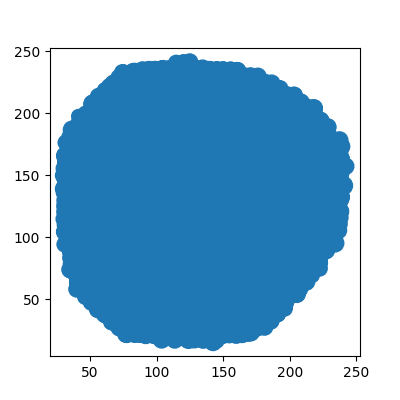

In [14]:
# Let's try a simple scatter plot first

fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(
    atoms[0],
    atoms[1],
    atoms[2],
);    # the ";" symbol suppresses the output

This plot is 2D and looks bad.  How do we fix it?

In matplotlib (compared to say matlab), 3D plotting needs to be specified when creating the figure axes.


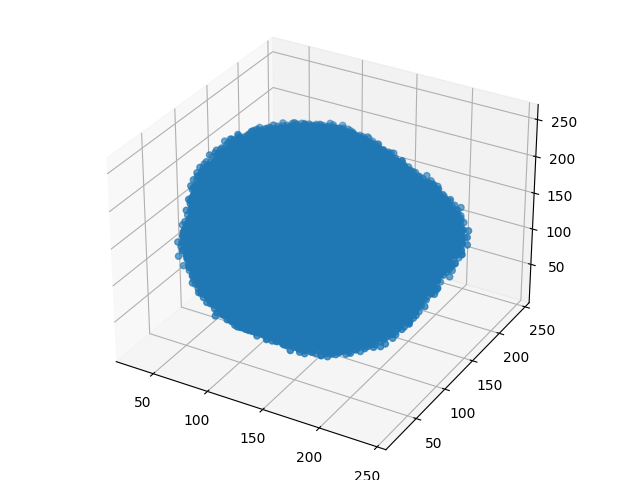

In [15]:
# Create 3D axes for our scatter plot
fig = plt.figure()
ax = fig.add_axes(
    rect = (0,0,1,1),
    projection = '3d',
)

ax.scatter(
    atoms[0],
    atoms[1],
    atoms[2],
);

Better - but the aspect ratio of the axes is not equal - the z axis is slightly squashed.

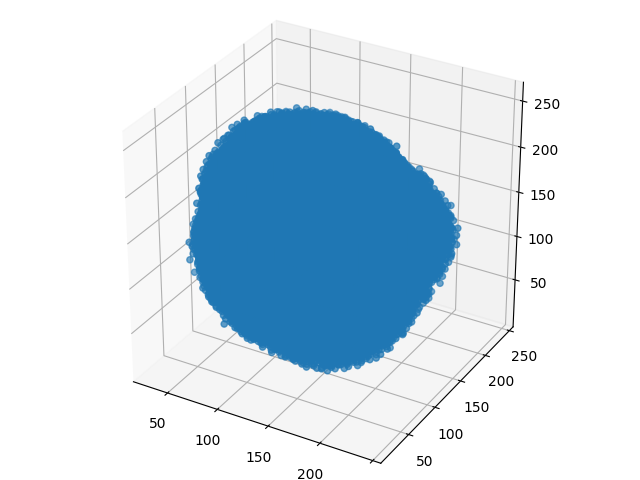

In [16]:
fig = plt.figure()
ax = fig.add_axes(
    rect = (0,0,1,1),
    projection = '3d',
)

ax.scatter(
    atoms[0],
    atoms[1],
    atoms[2],
);
ax.set_box_aspect((1,1,1))

We now have set up the correct axes. However, with so many overlapping points, we can't really see the 3D aspect of our atomic coordinates at all.  To plot atoms which appear 3D, we have 2 choices:

- Plot each site as a sphere. Much slower, but very accurate and makes high quality figures.
- Overlay circular markers to simulate shading, tinting, specular reflection, etc.

We're going with option 2 for now - matplotlib doesn't actually perform "true" 3D rendering. If you want to make very high quality 3D plots, there are better python packages (and Blender with its powerful python bindings).

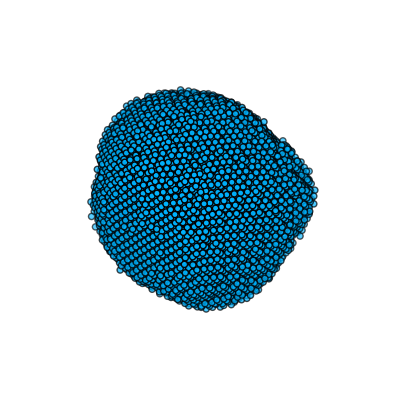

In [17]:
# We will use some scatter plot options to make our coordinates easier to interpret.
# We will also hide the axes labels.
fig = plt.figure(figsize = (4,4))
ax = fig.add_axes(
    rect = (0,0,1,1),
    projection = '3d',
)

ax.scatter(
    atoms[0],
    atoms[1],
    atoms[2],
    facecolor = (0,0.7,1,1),
    edgecolor = (0,0,0,1),
);
ax.set_box_aspect((1,1,1))
ax.axis('off');

Now it looks more like a nanoparticle!  Next we will position a camera so that we can choose the view direction of the particle we want to plot. In matplotlib, the simplest method to do this is to specify 3 Euler angles:

- elevation
- azimuth
- roll

We can also specify the camera distance, the camera target coordinate (where the camera is pointing at), and finally the field-of-view (or camera angle) which specifies the focal length for perspective plots. If we turn perspective off, sizes of plotting objects will not descrease with distance. Using either perspective or orthorgraphic plotting for 3D coordinates is usually a matter of personal preference.

In [26]:
# ax.set_proj_type?

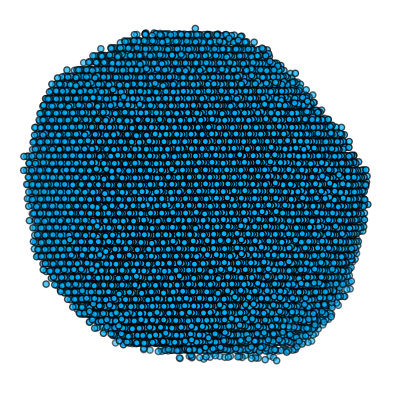

In [30]:
# We will use some scatter plot options to make our coordinates easier to interpret,
# and we will also hide the axes labels.
fig = plt.figure(figsize = (4,4))
ax = fig.add_axes(
    rect = (0,0,1,1),
    projection = '3d',
)

ax.scatter(
    atoms[0],
    atoms[1],
    atoms[2],
    facecolor = (0,0.7,1),
    edgecolor = (0,0,0),
);
ax.axis('off');
ax.view_init(
    elev = 00,
    azim = -30,
    roll = 0,
)
ax.set_proj_type(
    proj_type = 'ortho',
    # proj_type = 'persp',
    # focal_length = 0.05,  # try tweaking this value!
)
ax.set_box_aspect(
    (1,1,1),
    zoom = 1.6,
)

Next, lets focus on the markers themselves. We can improve their appearance in several ways such as increasing their size, and by adding the previously mentioned shading and specular reflections.

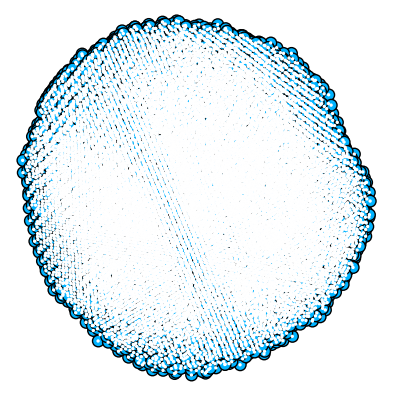

In [31]:
# More complex scatter plot options - feel free to tweak these values!
fig = plt.figure(figsize = (4,4))
ax = fig.add_axes(
    rect = (0,0,1,1),
    projection = '3d',
)

# atomic sites
ax.scatter(
    atoms[0],
    atoms[1],
    atoms[2],
    facecolor = (0,0.7,1),
    edgecolor = (0,0,0),
    s = 70,
    alpha = 1.0,
);
# specular reflections
shift = (0.4,-0.4,0.4)
ax.scatter(
    atoms[0] + shift[0],
    atoms[1] + shift[1],
    atoms[2] + shift[2],
    facecolor = (1,1,1),
    edgecolor = None,
    s = 2,
    alpha = 1.0,
);


# Plot appearance
ax.axis('off');
ax.view_init(
    elev = 30,
    azim = -30,
    roll = 0,
)
ax.set_proj_type(
    proj_type = 'persp',
    focal_length = 1.0,  # try tweaking this value!
)
ax.set_box_aspect(
    (1,1,1),
    zoom = 1.6,
)

Oops! What happened here?

As we previously noted, matplotlib doesn't support "real" 3D plotting. 3D plotting requires a "z-buffer" which posiitons objects along the projection direction - closer objects are drawn on top of further objects. Here our "specular reflection" scatter plot points are all drawn on top of the original marker coordinates.

To fix this, we need to either delete invisible objects (prone to error and difficult) or combine all of our markers into a single scatter plot function call. This is the preferred option, though we will need to manually specify the color of all markers. However, this will be very helpful for plotting improvements later in this tutorial.

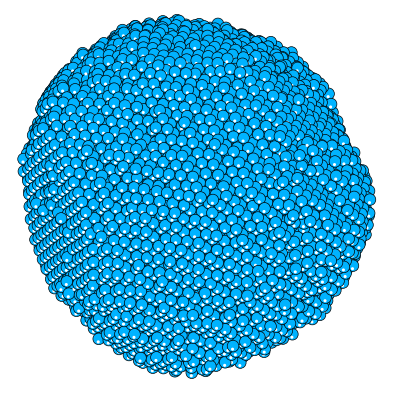

In [37]:
# Generate combined data, with these rows:
# 0-2 - x,y,z coordinates
# 3-5 - red,green,blue values
# 6   - size of marker
# 7   - linewidth (of edges)

num_atoms = atoms.shape[1]
atoms_rgb_size = np.zeros((8,num_atoms * 2))

inds = np.arange(num_atoms)
atoms_rgb_size[0:3,inds] = atoms[0:3,:]
atoms_rgb_size[3:6,inds] = np.array((0.0,0.7,1.0))[:,None]
atoms_rgb_size[6,inds]   = 70
atoms_rgb_size[7,inds]   = 0.5

shift = (1,-1,-1.6)
inds = np.arange(num_atoms,num_atoms*2)
atoms_rgb_size[0:3,inds] = atoms[0:3,:] + np.array(shift)[:,None]
atoms_rgb_size[3:6,inds] = np.array((1.0,1.0,1.0))[:,None]
atoms_rgb_size[6,inds]   = 5
atoms_rgb_size[7,inds]   = 0.0

# plotting
fig = plt.figure(figsize = (4,4))
ax = fig.add_axes(
    rect = (0,0,1,1),
    projection = '3d',
)

# atomic sites
ax.scatter(
    atoms_rgb_size[0],
    atoms_rgb_size[1],
    atoms_rgb_size[2],
    c = atoms_rgb_size[3:6,:].T,
    s = atoms_rgb_size[6,:],
    linewidth = atoms_rgb_size[7,:],
    edgecolor = (0,0,0),
    alpha = 1.0,
);


# Plot appearance
ax.axis('off');
ax.view_init(
    elev = 30,
    azim = -30,
    roll = 0,
)
ax.set_proj_type(
    proj_type = 'persp',
    focal_length = 1.0,  # try tweaking this value!
)
ax.set_box_aspect(
    (1,1,1),
    zoom = 1.6,
)

In [33]:
atoms_rgb_size.shape

(8, 46392)

This plot looks pretty reasonable. However why not take this approach to its logical conclusion?

Instead of plotting 2 overlapping circles, lets set up the plot to use any number of circles!  We can overlap different circles to create the illusion of shading:

[image]

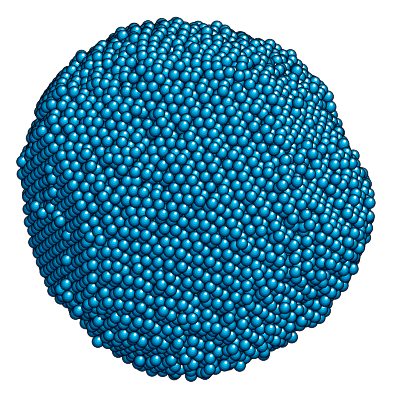

In [41]:
# Use an array to hold the different positions, colors, linewiths, etc.

data = np.array([
    [0.0,0.0,0.0, 0.0,0.2,0.4, 70, 0.5],
    [0.0,0.2,0.4, 0.0,0.4,0.6, 50, 0.0],
    [0.0,0.4,0.8, 0.0,0.6,0.8, 30, 0.0],
    [0.0,0.6,1.2, 0.0,0.8,1.0, 10, 0.0],

    [0.0,1.0,2.0, 1.0,1.0,1.0,  4, 0.0],
])
num_atoms = atoms.shape[1]
atoms_rgb_size = np.zeros((8,num_atoms * data.shape[0]))
for a0 in range(data.shape[0]):
    inds = np.arange(num_atoms) + a0 * num_atoms
    atoms_rgb_size[0:3,inds] = atoms[0:3,:] + np.array(data[a0,0:3])[:,None]
    atoms_rgb_size[3:6,inds] = np.array(data[a0,3:6])[:,None]
    atoms_rgb_size[6,inds]   = np.array(data[a0,6])
    atoms_rgb_size[7,inds]   = np.array(data[a0,7])


# plotting
fig = plt.figure(figsize = (4,4))
ax = fig.add_axes(
    rect = (0,0,1,1),
    projection = '3d',
)

# atomic sites
ax.scatter(
    atoms_rgb_size[0],
    atoms_rgb_size[1],
    atoms_rgb_size[2],
    c = atoms_rgb_size[3:6,:].T,
    s = atoms_rgb_size[6,:],
    linewidth = atoms_rgb_size[7,:],
    edgecolor = (0,0,0),
    alpha = 1.0,
);


# Plot appearance
ax.axis('off');
ax.view_init(
    elev = 30,
    azim = -30,
    roll = 0,
)
ax.set_proj_type(
    proj_type = 'persp',
    focal_length = 1.0,  # try tweaking this value!
)
ax.set_box_aspect(
    (1,1,1),
    zoom = 1.6,
)

This effect has been achieved using only 2D markers - we have only approximated the 3D shading which real spheres would have.

The next step is to color the different atomic species - in the case of this particle, site ID = 1 corresponds to Fe, and site ID = 2 corresponds to Pt. We will color the Fe sites red.

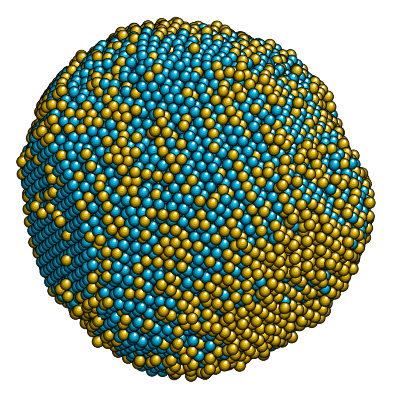

In [44]:


# Get a vector of boolean values (True or False) for each site.
sub_1 = atoms[3,:] == 1
sub_2 = atoms[3,:] == 2

# parent colors for the 2 site types
c_1 = np.array((1.0, 0.8, 0.0))
c_2 = np.array((0.0, 0.8, 1.0))
c_t = np.array((1.0, 1.0, 1.0))

# We will modify our data structure so that instead of specifying the
# (red,green,blue) values, we have a column for "shading" and a column for "tinting."
data = np.array([
    [0.0,0.0,0.0, 0.25, 0.0, 70, 0.5],
    [0.0,0.2,0.4, 0.50, 0.0, 50, 0.0],
    [0.0,0.4,0.8, 0.75, 0.0, 30, 0.0],
    [0.0,0.6,1.2, 1.00, 0.0, 10, 0.0],

    [0.0,1.0,2.0, 0.00, 1.0,  4, 0.0],
])
num_atoms = atoms.shape[1]
atoms_rgb_size = np.zeros((8,num_atoms * data.shape[0]))
for a0 in range(data.shape[0]):
    inds = np.arange(num_atoms) + a0 * num_atoms
    atoms_rgb_size[0:3,inds] = atoms[0:3,:] + np.array(data[a0,0:3])[:,None]
    atoms_rgb_size[6,inds]   = np.array(data[a0,5])
    atoms_rgb_size[7,inds]   = np.array(data[a0,6])

    # New coloring logic
    c = (sub_1[None,:] * c_1[:,None]) * data[a0,3] + \
        (sub_2[None,:] * c_2[:,None]) * data[a0,3] + \
        c_t[:,None] * data[a0,4]
    atoms_rgb_size[3:6,inds] = c


# plotting
fig = plt.figure(figsize = (4,4))
ax = fig.add_axes(
    rect = (0,0,1,1),
    projection = '3d',
)

# atomic sites
ax.scatter(
    atoms_rgb_size[0],
    atoms_rgb_size[1],
    atoms_rgb_size[2],
    c = atoms_rgb_size[3:6,:].T,
    s = atoms_rgb_size[6,:],
    linewidth = atoms_rgb_size[7,:],
    edgecolor = (0,0,0),
    alpha = 1.0,
);


# Plot appearance
ax.axis('off');
ax.view_init(
    elev = 30,
    azim = -30,
    roll = 0,
)
ax.set_proj_type(
    proj_type = 'persp',
    focal_length = 1.0,  # try tweaking this value!
)
ax.set_box_aspect(
    (1,1,1),
    zoom = 1.6,
)

Much more informative! Now the atom species are clearly labeled.

However, we would like to see "inside" the particle to understand its internal structure. The simplest way to accomplish this goal is to split apart the particle, and plot "slices" of the internal structure. We will use the known plane spacing of atoms_data of ~10.38.  We could also use the information stored in atoms_lattice (which are the indexed lattice coordinates) but that is beyond the scope of this tutorial.

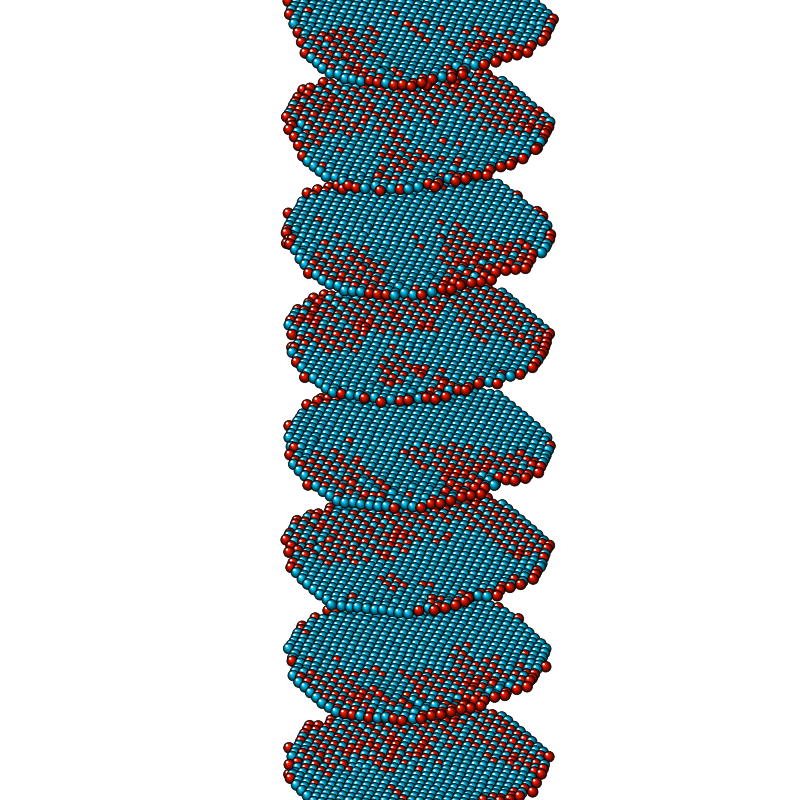

In [49]:
# Define our desired slice thickness and offset, and the plotting separation.
dz = 10.38
z_slice = 0.5 * dz
z_offset = -1.5 * dz
z_plot_shift = 100

# Assign the coordinates to their slices
slice_ID = np.round((atoms[2,:] - z_offset) / z_slice)

# Copy the coordinates and apply the desired shifts
atoms_shift = atoms.copy()
atoms_shift[2,:] += slice_ID * z_plot_shift

# plotting code
# Get a vector of boolean values (True or False) for each site.
sub_1 = atoms[3,:] == 1
sub_2 = atoms[3,:] == 2

# parent colors for the 2 site types
c_1 = np.array((1.0, 0.1, 0.0))
c_2 = np.array((0.0, 0.8, 1.0))
c_t = np.array((1.0, 1.0, 1.0))

# We will modify our data structure so that instead of specifying the
# (red,green,blue) values, we have a column for "shading" and a column for "tinting."
data = np.array([
    [0.0,0.0,0.0, 0.25, 0.0, 60, 0.5],
    [0.0,0.4,0.6, 0.50, 0.0, 40, 0.0],
    [0.0,0.8,1.2, 0.75, 0.0, 20, 0.0],
    [0.0,1.2,1.8, 1.00, 0.0, 8, 0.0],

    [0.0,2.0,3.0, 0.00, 1.0,  3, 0.0],
])
num_atoms = atoms.shape[1]
atoms_rgb_size = np.zeros((8,num_atoms * data.shape[0]))
for a0 in range(data.shape[0]):
    inds = np.arange(num_atoms) + a0 * num_atoms
    atoms_rgb_size[0:3,inds] = atoms_shift[0:3,:] + np.array(data[a0,0:3])[:,None]
    atoms_rgb_size[6,inds]   = np.array(data[a0,5])
    atoms_rgb_size[7,inds]   = np.array(data[a0,6])

    # New coloring logic
    c = (sub_1[None,:] * c_1[:,None]) * data[a0,3] + \
        (sub_2[None,:] * c_2[:,None]) * data[a0,3] + \
        c_t[:,None] * data[a0,4]
    atoms_rgb_size[3:6,inds] = c


# plotting
fig = plt.figure(figsize = (8,8))
ax = fig.add_axes(
    rect = (0,0,1,1),
    projection = '3d',
)

# atomic sites
ax.scatter(
    atoms_rgb_size[0],
    atoms_rgb_size[1],
    atoms_rgb_size[2],
    c = atoms_rgb_size[3:6,:].T,
    s = atoms_rgb_size[6,:],
    linewidth = atoms_rgb_size[7,:],
    edgecolor = (0,0,0),
    alpha = 1.0,
);


# Plot appearance
ax.axis('off');
ax.view_init(
    elev = 30,
    azim = 150,
    roll = 0,
)
# ax.set_proj_type(
#     proj_type = 'persp',
#     focal_length = 1.0,  # try tweaking this value!
# )
ax.set_proj_type(
    proj_type = 'ortho',
)
ax.set_box_aspect(
    (
        np.ptp(atoms_rgb_size[0]),
        np.ptp(atoms_rgb_size[1]),
        np.ptp(atoms_rgb_size[2]),
    ),
    zoom = 8.0,
)

This looks ok, but the checkerboard L12 atomic structure isn't as nice to look at as perhaps the other 2 principal axes. Let's try splitting the particle along the x direction.

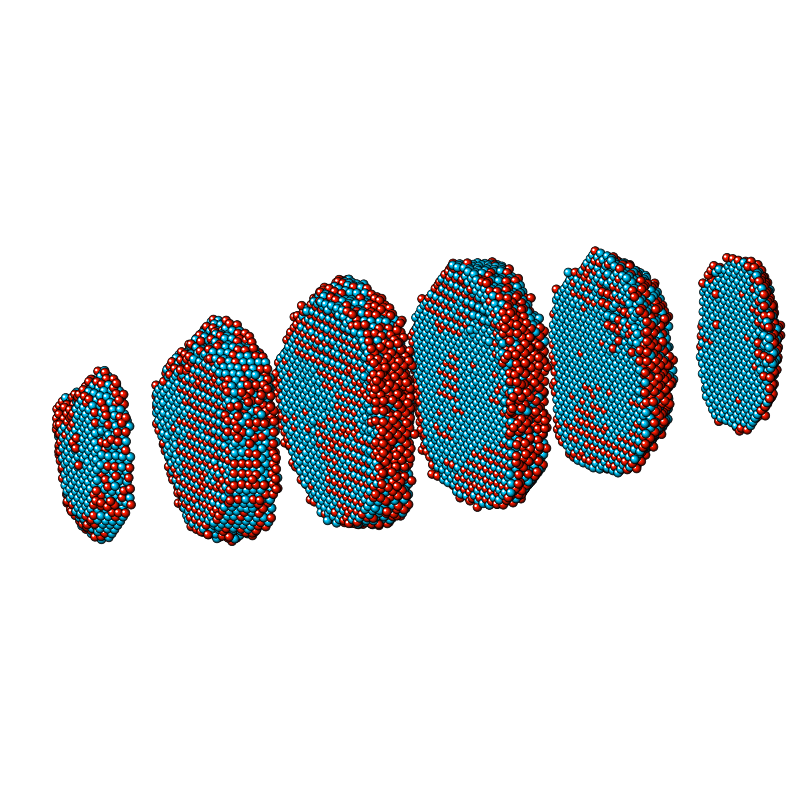

In [50]:
# Define our desired slice thickness and offset, and the plotting separation.
dy = 10.38
y_slice = 4.0 * dy
y_offset = -1.45 * dy
y_plot_shift = 110

# Assign the coordinates to their slices
slice_ID = np.round((atoms[1,:] - y_offset) / y_slice)

# Copy the coordinates and apply the desired shifts
atoms_shift = atoms.copy()
atoms_shift[1,:] += slice_ID * y_plot_shift

# plotting code
# Get a vector of boolean values (True or False) for each site.
sub_1 = atoms[3,:] == 1
sub_2 = atoms[3,:] == 2

# parent colors for the 2 site types
c_1 = np.array((1.0, 0.1, 0.0))
c_2 = np.array((0.0, 0.8, 1.0))
c_t = np.array((1.0, 1.0, 1.0))

# We will modify our data structure so that instead of specifying the
# (red,green,blue) values, we have a column for "shading" and a column for "tinting."
data = np.array([
    [0.0,0.0,0.0, 0.25, 0.0, 40, 0.5],
    [0.0,0.4,0.3, 0.50, 0.0, 30, 0.0],
    [0.0,0.8,0.6, 0.75, 0.0, 20, 0.0],
    [0.0,1.2,0.9, 1.00, 0.0, 10, 0.0],

    [0.0,2.0,1.5, 0.00, 1.0,  3, 0.0],
])
num_atoms = atoms.shape[1]
atoms_rgb_size = np.zeros((8,num_atoms * data.shape[0]))
for a0 in np.arange(data.shape[0]):
    inds = np.arange(num_atoms) + a0 * num_atoms
    atoms_rgb_size[0:3,inds] = atoms_shift[0:3,:] + np.array(data[a0,0:3])[:,None]
    atoms_rgb_size[6,inds]   = np.array(data[a0,5])
    atoms_rgb_size[7,inds]   = np.array(data[a0,6])

    # New coloring logic
    c = (sub_1[None,:] * c_1[:,None]) * data[a0,3] + \
        (sub_2[None,:] * c_2[:,None]) * data[a0,3] + \
        c_t[:,None] * data[a0,4]
    atoms_rgb_size[3:6,inds] = c


# plotting
fig = plt.figure(
    figsize = (8,8),
)
ax = fig.add_axes(
    rect = (0,0,1,1),
    projection = '3d',
)

# atomic sites
ax.scatter(
    atoms_rgb_size[0],
    atoms_rgb_size[1],
    atoms_rgb_size[2],
    c = atoms_rgb_size[3:6,:].T,
    s = atoms_rgb_size[6,:],
    linewidth = atoms_rgb_size[7,:],
    edgecolor = (0,0,0),
    alpha = 1.0,
);


# Plot appearance
ax.axis('off');
ax.view_init(
    elev = 15,
    azim = 150,
    roll = 0,
)
# ax.set_proj_type(
#     proj_type = 'persp',
#     focal_length = 1.0,  # try tweaking this value!
# )
ax.set_proj_type(
    proj_type = 'ortho',
)
ax.set_box_aspect(
    (
        np.ptp(atoms_rgb_size[0]),
        np.ptp(atoms_rgb_size[1]),
        np.ptp(atoms_rgb_size[2]),
    ),
    zoom = 1.2,
    # aspect=None,
)

# ax.patch.set_linewidth(10)
# ax.patch.set_edgecolor('cyan')

# fig.patch.set_linewidth(10)
# fig.patch.set_edgecolor('red')


This is getting close to the desired final plot. However notice how the slices look "flat?"  We can try to improve the appearance using a subtle coloring method known as "depth cueing."

Using depth cueing means that objects which are far away are either shaded or tinted to fall into the background. Your brain interprets this as a 3D effect, assuming that more washed out objects are further away.  Lets give it a try!

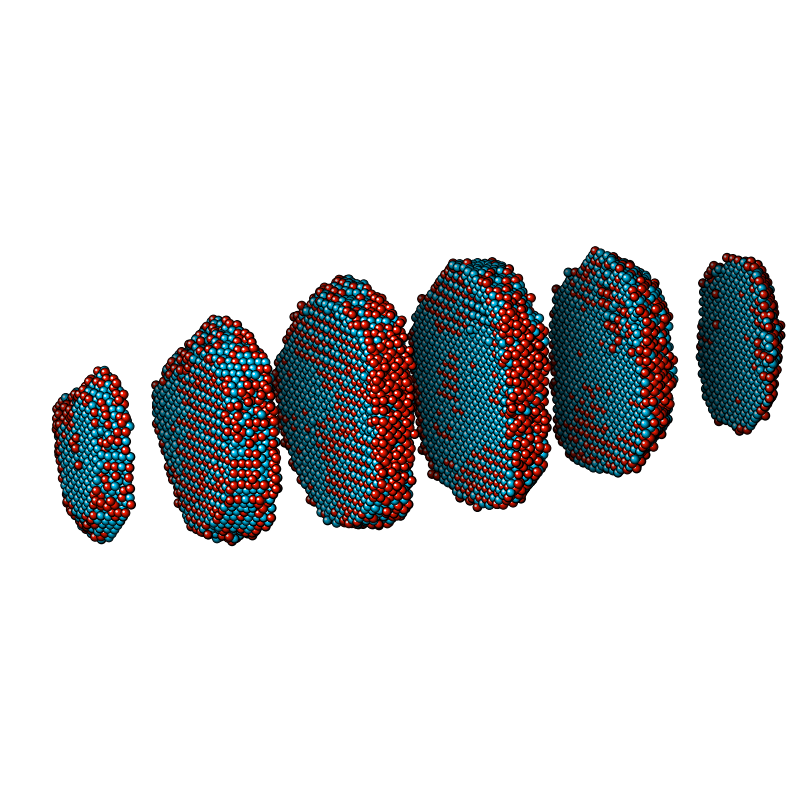

In [55]:
# Depth cueing variables
bg_color = np.array((0.0,0.0,0.0))
bg_power_law = 1.5
bg_scale = 0.8
cam_pos = np.array((-5.0,1.0,1.0)) * 1000


# Define our desired slice thickness and offset, and the plotting separation.
dy = 10.38
y_slice = 4.0 * dy
y_offset = -1.45 * dy
y_plot_shift = 110

# Assign the coordinates to their slices
slice_ID = np.round((atoms[1,:] - y_offset) / y_slice)

# Copy the coordinates and apply the desired shifts
atoms_shift = atoms.copy()
atoms_shift[1,:] += slice_ID * y_plot_shift

# plotting code
# Get a vector of boolean values (True or False) for each site.
sub_1 = atoms[3,:] == 1
sub_2 = atoms[3,:] == 2

# parent colors for the 2 site types
c_1 = np.array((1.0, 0.1, 0.0))
c_2 = np.array((0.0, 0.8, 1.0))
c_t = np.array((1.0, 1.0, 1.0))

# We will modify our data structure so that instead of specifying the
# (red,green,blue) values, we have a column for "shading" and a column for "tinting."
data = np.array([
    [0.0,0.0,0.0, 0.00, 0.0, 50, 0.0],
    [0.0,0.0,0.0, 0.25, 0.0, 40, 0.0],
    [0.0,0.4,0.3, 0.50, 0.0, 30, 0.0],
    [0.0,0.8,0.6, 0.75, 0.0, 20, 0.0],
    [0.0,1.2,0.9, 1.00, 0.0, 10, 0.0],

    [0.0,2.0,1.5, 0.00, 1.0,  3, 0.0],
])
num_atoms = atoms.shape[1]
atoms_rgb_size = np.zeros((8,num_atoms * data.shape[0]))
for a0 in range(data.shape[0]):
    inds = np.arange(num_atoms) + a0 * num_atoms
    atoms_rgb_size[0:3,inds] = atoms_shift[0:3,:] + np.array(data[a0,0:3])[:,None]
    atoms_rgb_size[6,inds]   = np.array(data[a0,5])
    atoms_rgb_size[7,inds]   = np.array(data[a0,6])

    # New coloring logic
    c = (sub_1[None,:] * c_1[:,None]) * data[a0,3] + \
        (sub_2[None,:] * c_2[:,None]) * data[a0,3] + \
        c_t[:,None] * data[a0,4]
    atoms_rgb_size[3:6,inds] = c

# Apply depth cueing
dist = np.sqrt(np.sum((atoms_rgb_size[0:3,:] - cam_pos[:,None])**2,axis = 0))
dist -= np.min(dist)
dist /= np.max(dist)  # scale to be 0 to 1
dist **= bg_power_law
dist *= bg_scale
atoms_rgb_size[3:6,:] = atoms_rgb_size[3:6,:] * (1-dist) + bg_color[:,None] * dist

# plotting
fig = plt.figure(
    figsize = (8,8),
)
ax = fig.add_axes(
    rect = (0,0,1,1),
    projection = '3d',
)

# atomic sites
ax.scatter(
    atoms_rgb_size[0],
    atoms_rgb_size[1],
    atoms_rgb_size[2],
    c = atoms_rgb_size[3:6,:].T,
    s = atoms_rgb_size[6,:],
    linewidth = atoms_rgb_size[7,:],
    edgecolor = (0,0,0),
    alpha = 1.0,
);


# Plot appearance
ax.axis('off');
ax.view_init(
    elev = 15,
    azim = 150,
    roll = 0,
)
ax.set_proj_type(
    proj_type = 'ortho',
)
ax.set_box_aspect(
    (
        np.ptp(atoms_rgb_size[0]),
        np.ptp(atoms_rgb_size[1]),
        np.ptp(atoms_rgb_size[2]),
    ),
    zoom = 1.2,
)


Looks pretty good, though there are some inconguities - for example the white specular reflection is shadowed the same as the diffuse colored atoms.  We will tackle this issue in the next section.

### Exercise 1 - Plot nanoparticle internal surface

Plot the nanoparticle as a hollow hemisphere, in order to see the internal structure.  Make the inner radius a user-specified variable.

In [59]:
# Answer 1 -



### Pair distribution function (PDF)

One of the most useful statistics we could compute from a set of atomic coordinates is the pair distribution funciton (PDF).  The naive way to calculate the PDF is to compare every atomic coordinate against every other one. For N coordinates, this requires N^2 calculations. Can we do better?

There are many methods which can optimize this calculation. Here we will demonstrate how to use a numpy array as a lookup table for the local coordinates. This will allow us to calculate a set of nearest neighbors, and then we can compute the PDF only including these neighboring sites.

In [60]:
radius_check = 20.0
dr = 2.0

# Determine the range of coordinates needed
r = np.ceil(radius_check / dr).astype('int')
xyz_ind = np.round(atoms[0:3,:] / dr).astype('int')
xyz_ind -= np.min(xyz_ind,axis=1)[:,None]
xyz_ind += r
xyz_size = np.max(xyz_ind,axis=1) + r + 1

vol = np.ones(xyz_size) * -1
vol[xyz_ind[0],
    xyz_ind[1],
    xyz_ind[2],
] = np.arange(num_atoms)

# Make list of NNs
NN_list = []
v = np.arange(-r,r+1)
vx = v[:,None,None]
vy = v[None,:,None]
vz = v[None,None,:]

r2 = radius_check**2
for a0 in range(num_atoms):
    vol_crop = vol[
        xyz_ind[0,a0] + vx,
        xyz_ind[1,a0] + vy,
        xyz_ind[2,a0] + vz,
    ]

    nn_inds = np.unique(vol_crop)
    nn_inds = nn_inds[nn_inds>=0].astype('int')

    dist = np.sum((atoms[0:3,nn_inds] - atoms[0:3,a0][:,None])**2, axis = 0)
    keep = np.logical_and(
        dist > 1e-6,
        dist <= r2,
    )
    NN_list.append(nn_inds[keep])

In [61]:
# Now that we have a list of the NN sites, we can compute a PDF histogram

r_bins = np.arange(
    0.0,
    radius_check,
    0.1,
)
PDF = np.zeros_like(r_bins)
dr = r_bins[1] - r_bins[0]

for a0 in range(num_atoms):
    nn_inds = NN_list[a0]

    dist = np.sqrt(np.sum((atoms[0:3,nn_inds] - atoms[0:3,a0][:,None])**2, axis=0))

    r_inds = np.round(dist / dr).astype('int')
    keep = r_inds < r_bins.shape[0]

    PDF += np.bincount(
        r_inds[keep],
        minlength = r_bins.shape[0]
    )

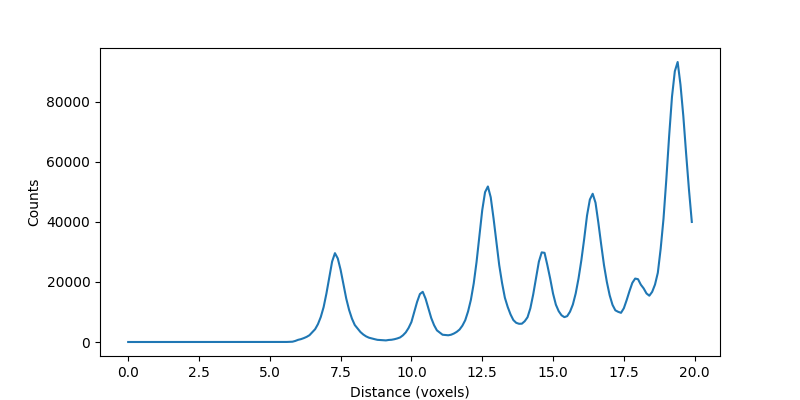

In [62]:
# And finally, lets plot this histogram
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(
    r_bins,
    PDF,
)
ax.set_xlabel('Distance (voxels)')
ax.set_ylabel('Counts');

### Exercise 2 - create histogram of local chemistry

Instead of plotting the PDF, modify the above code to plot a histogram of the nearest neighbors


In [63]:
# Answer 2 -

# Ray tracing

Let's try one more complex plotting trick - ray tracing!  Ray tracing seems complex (and it is on a modern GPU), but functionally it just means creating vectors between objects and light sources, and determining if they intersect other objects. In this case, we will calculate whether or not each atom is illuminated or not.

Note that this calculation would take a very long time if we compared every site with every other site!  Similar to the PDF section above, we will use the list of nearest neighbors for checking.

In [64]:
# Define our desired slice thickness and offset, and the plotting separation.
dy = 10.38
y_slice = 4.0 * dy
y_offset = -1.45 * dy
y_plot_shift = 110

# Assign the coordinates to their slices
slice_ID = np.round((atoms[1,:] - y_offset) / y_slice)

# Copy the coordinates and apply the desired shifts
atoms_shift = atoms.copy()
atoms_shift[1,:] += slice_ID * y_plot_shift

In [65]:
# Construct the same volume as before, but from the shifted coordinates.
# Note that we can use a much smaller dr, since a few overlapping sites
# won't affect the plot much.
radius_shadow = 9.0
dr = 8.0

# Determine the range of coordinates needed
r = np.ceil(radius_shadow / dr).astype('int')
xyz_ind = np.round(atoms_shift[0:3,:] / dr).astype('int')
xyz_ind -= np.min(xyz_ind,axis=1)[:,None]
xyz_ind += r
xyz_size = np.max(xyz_ind,axis=1) + r + 1

vol = np.ones(xyz_size) * -1
vol[xyz_ind[0],
    xyz_ind[1],
    xyz_ind[2],
] = np.arange(num_atoms)


In [66]:
# Now we will use this volume to determine which sites are shaded and which are lit.
# light_vec = np.array((-0.4,1.0,0.0))
# light_vec = np.array((-0.8,1.2,0.4))
light_vec = np.array((-0.8,1.2,-0.4))
offset = 4.0
steps = 32

# Get set of vectors to shift volume by
light_vec /= np.linalg.norm(light_vec)
vec = light_vec[:,None] * (np.arange(0.0,steps,1.0) + offset)[None,:]
print(vec[:,0])

# Construct shadow volume
vol_site = vol >= 0
vol_shadow = np.zeros_like(vol, dtype='bool')

for a0 in range(steps):
    shift = np.round(-1*vec[:,a0]).astype('int')

    vol_shift = np.roll(
        vol_site,
        shift,
        axis = (0,1,2),
    )

    if shift[0] > 0:
        vol_shift[:shift[0],:,:] = False
    elif shift[0] < 0:
        vol_shift[shift[0]:,:,:] = False
    if shift[1] > 0:
        vol_shift[:,:shift[1],:] = False
    elif shift[1] < 0:
        vol_shift[:,shift[1]:,:] = False
    if shift[2] > 0:
        vol_shift[:,:,:shift[2]] = False
    elif shift[2] < 0:
        vol_shift[:,:,shift[2]:] = False

    vol_shadow = np.logical_or(
        vol_shadow,
        vol_shift,
    )



[-2.13808994  3.2071349  -1.06904497]


In [67]:
# We can slightly expand the shadow volume to ensure all sites in shadow are caught

vol_shadow = np.logical_or.reduce((
    vol_shadow,
    np.roll(vol_shadow, 1,axis=0),
    np.roll(vol_shadow,-1,axis=0),
    np.roll(vol_shadow, 1,axis=1),
    np.roll(vol_shadow,-1,axis=1),
    np.roll(vol_shadow, 1,axis=2),
    np.roll(vol_shadow,-1,axis=2),
))

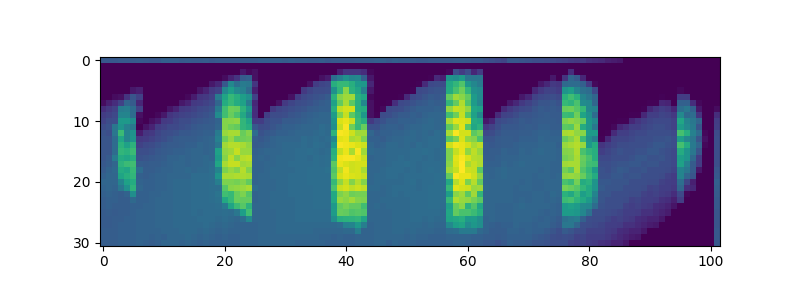

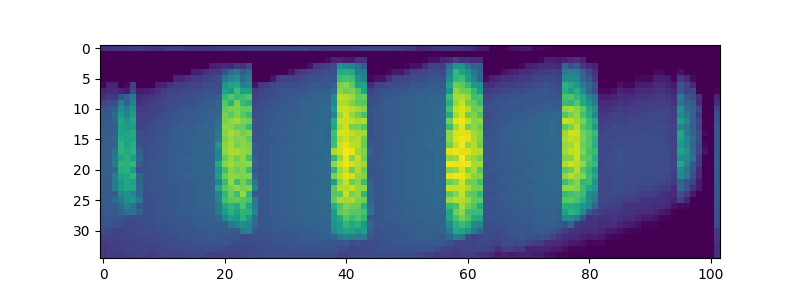

In [68]:
# Here is a quick visualization to demonstrate what we're doing

fig,ax = plt.subplots(figsize=(8,3))
ax.imshow(
    np.sum(
        vol_shadow > 0,
        axis = 2,
    ) + np.sum(
        vol_site,
        axis = 2,
    ) * 2.0
);
fig,ax = plt.subplots(figsize=(8,3))
ax.imshow(
    np.sum(
        vol_shadow > 0,
        axis = 0,
    ).T + np.sum(
        vol_site,
        axis = 0,
    ).T * 2.0
);

In [69]:
# Next, we evaluate which sites are lit and which are in shadow

inds_3D = np.ravel_multi_index(
    # (
    #     xyz_ind[0],
    #     xyz_ind[0],
    #     xyz_ind[0],
    # ),
    xyz_ind,
    vol.shape,
)

atoms_lit = np.logical_not(
    vol_shadow.ravel()[inds_3D],
)

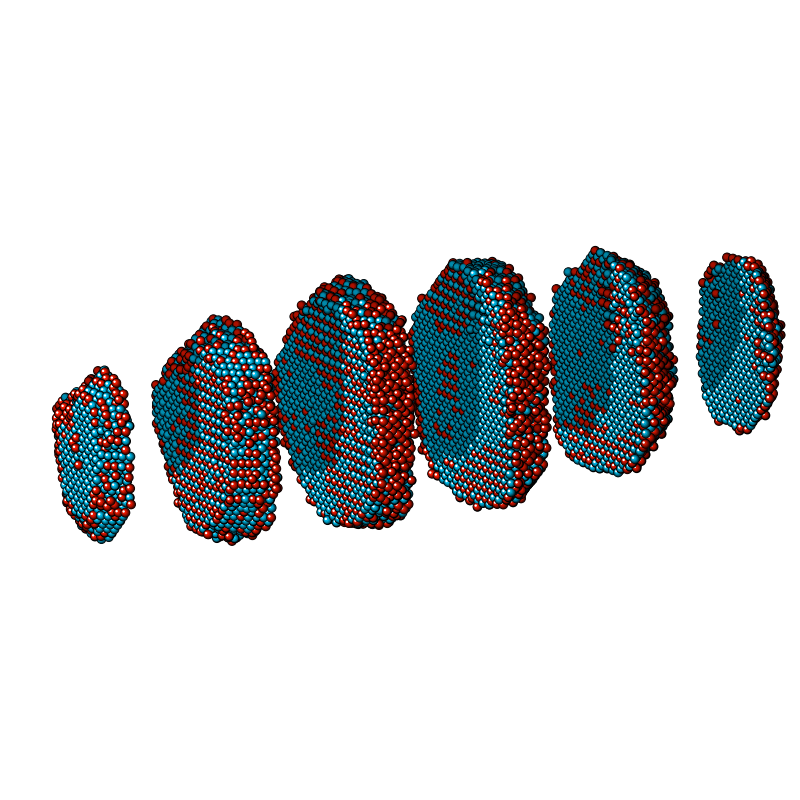

In [70]:
# Combined plotting

# shading variables
shadow_scale = 0.3   # How much to decrease colors of objects in shadow
bg_color = np.array((0.0,0.0,0.0))
bg_power_law = 1.5
bg_scale = 0.2
cam_pos = np.array((4.0,1.0,1.0)) * 1000

# plotting code
# Get a vector of boolean values (True or False) for each site.
sub_1 = atoms[3,:] == 1
sub_2 = atoms[3,:] == 2

# parent colors for the 2 site types
c_1 = np.array((1.0, 0.1, 0.0))
c_2 = np.array((0.0, 0.8, 1.0))
c_t = np.array((1.0, 1.0, 1.0))

# We will modify our data structure so that instead of specifying the
# (red,green,blue) values, we have a column for "shading" and a column for "tinting."
data = np.array([
    [0.0,0.0,0.0, 0.00, 0.0, 50, 0.0],
    [0.0,0.0,0.0, 0.25, 0.0, 40, 0.0],
    [0.0,0.4,0.3, 0.50, 0.0, 30, 0.0],
    [0.0,0.8,0.6, 0.75, 0.0, 20, 0.0],
    [0.0,1.2,0.9, 1.00, 0.0, 10, 0.0],

    [0.0,2.0,1.5, 0.00, 1.0,  3, 0.0],
])

# depth cueing
dist_vec = atoms_shift[0:3,:] - cam_pos[:,None]
dist = np.sqrt(np.sum(dist_vec**2,axis = 0))
dist -= np.min(dist)
dist /= np.max(dist)  # scale to be 0 to 1
dist **= bg_power_law
dist *= bg_scale


# Main coloring loop
atoms_rgb_size = np.zeros((8,num_atoms * data.shape[0]))
atoms_rgb_del = np.zeros(num_atoms * data.shape[0],dtype='bool')
for a0 in np.arange(data.shape[0]):
    inds = np.arange(num_atoms) + a0 * num_atoms
    atoms_rgb_size[0:3,inds] = atoms_shift[0:3,:] + np.array(data[a0,0:3])[:,None]
    atoms_rgb_size[6,inds]   = np.array(data[a0,5])
    atoms_rgb_size[7,inds]   = np.array(data[a0,6])

    # New coloring logic
    c = (sub_1[None,:] * c_1[:,None]) * data[a0,3] + \
        (sub_2[None,:] * c_2[:,None]) * data[a0,3]
    if data[a0,4] > 0.9999:
        atoms_rgb_size[3:6,inds[atoms_lit]] = c_t[:,None]
        atoms_rgb_del[inds[np.logical_not(atoms_lit)]] = True
    else:
        atoms_rgb_size[3:6,inds] = \
        (c * (1-dist) + bg_color[:,None] * dist) * \
        (atoms_lit * shadow_scale + (1 - shadow_scale))

# Delete bad sites
atoms_rgb_size = np.delete(
    atoms_rgb_size,
    atoms_rgb_del,
    axis = 1,
)

# plotting
fig = plt.figure(
    figsize = (8,8),
)
ax = fig.add_axes(
    rect = (0,0,1,1),
    projection = '3d',
)

# atomic sites
ax.scatter(
    atoms_rgb_size[0],
    atoms_rgb_size[1],
    atoms_rgb_size[2],
    c = atoms_rgb_size[3:6,:].T,
    s = atoms_rgb_size[6,:],
    linewidth = atoms_rgb_size[7,:],
    edgecolor = (0,0,0),
    alpha = 1.0,
)


# Plot appearance
ax.axis('off');
ax.view_init(
    elev = 15,
    azim = 150,
    roll = 0,
)
ax.set_proj_type(
    proj_type = 'ortho',
)
ax.set_box_aspect(
    (
        np.ptp(atoms_rgb_size[0]),
        np.ptp(atoms_rgb_size[1]),
        np.ptp(atoms_rgb_size[2]),
    ),
    zoom = 1.2,
)

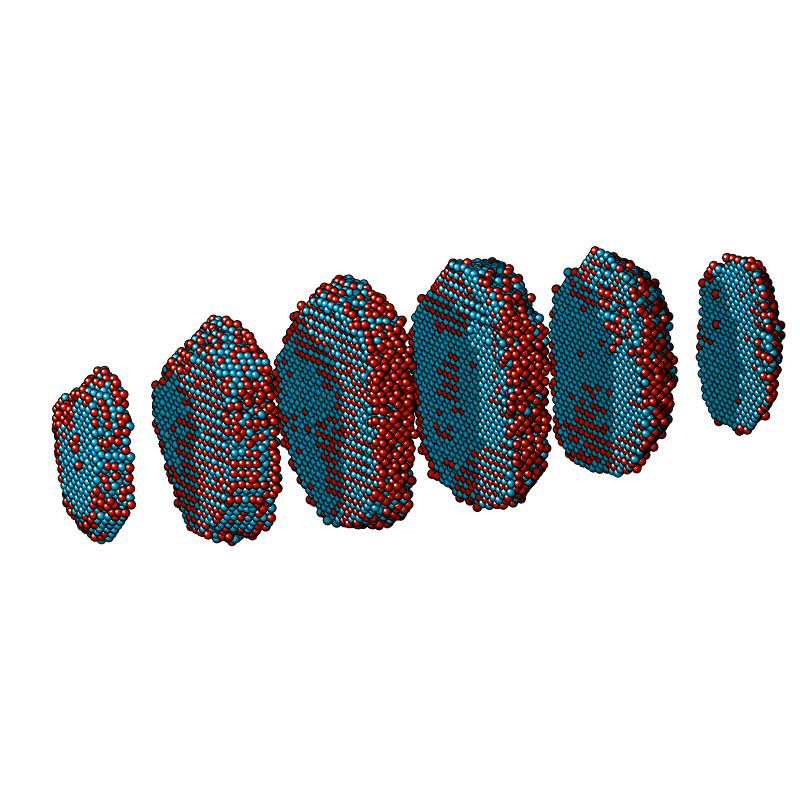

In [ ]:
# Combined plotting

# shading variables
shadow_scale = 0.3   # How much to decrease colors of objects in shadow
bg_color = np.array((0.0,0.0,0.0))
bg_power_law = 1.5
bg_scale = 0.2
cam_pos = np.array((4.0,1.0,1.0)) * 1000

# plotting code
# Get a vector of boolean values (True or False) for each site.
sub_1 = atoms[3,:] == 1
sub_2 = atoms[3,:] == 2

# parent colors for the 2 site types
c_1 = np.array((1.0, 0.1, 0.0))
c_2 = np.array((0.0, 0.8, 1.0))
c_t = np.array((1.0, 1.0, 1.0))

# We will modify our data structure so that instead of specifying the
# (red,green,blue) values, we have a column for "shading" and a column for "tinting."
data = np.array([
    [0.0,0.0,0.0, 0.00, 0.0, 50, 0.0],
    [0.0,0.0,0.0, 0.25, 0.0, 40, 0.0],
    [0.0,0.4,0.3, 0.50, 0.0, 30, 0.0],
    [0.0,0.8,0.6, 0.75, 0.0, 20, 0.0],
    [0.0,1.2,0.9, 1.00, 0.0, 10, 0.0],

    [0.0,2.0,1.5, 0.00, 1.0,  3, 0.0],
])

# depth cueing
dist_vec = atoms_shift[0:3,:] - cam_pos[:,None]
dist = np.sqrt(np.sum(dist_vec**2,axis = 0))
dist -= np.min(dist)
dist /= np.max(dist)  # scale to be 0 to 1
dist **= bg_power_law
dist *= bg_scale


# Main coloring loop
atoms_rgb_size = np.zeros((8,num_atoms * data.shape[0]))
atoms_rgb_del = np.zeros(num_atoms * data.shape[0],dtype='bool')
for a0 in np.arange(data.shape[0]):
    inds = np.arange(num_atoms) + a0 * num_atoms
    atoms_rgb_size[0:3,inds] = atoms_shift[0:3,:] + np.array(data[a0,0:3])[:,None]
    atoms_rgb_size[6,inds]   = np.array(data[a0,5])
    atoms_rgb_size[7,inds]   = np.array(data[a0,6])

    # New coloring logic
    c = (sub_1[None,:] * c_1[:,None]) * data[a0,3] + \
        (sub_2[None,:] * c_2[:,None]) * data[a0,3]
    if data[a0,4] > 0.9999:
        atoms_rgb_size[3:6,inds[atoms_lit]] = c_t[:,None]
        atoms_rgb_del[inds[np.logical_not(atoms_lit)]] = True
    else:
        atoms_rgb_size[3:6,inds] = \
        (c * (1-dist) + bg_color[:,None] * dist) * \
        (atoms_lit * shadow_scale + (1 - shadow_scale))

# Delete bad sites
atoms_rgb_size = np.delete(
    atoms_rgb_size,
    atoms_rgb_del,
    axis = 1,
)

# plotting
fig = plt.figure(
    figsize = (8,8),
)
ax = fig.add_axes(
    rect = (0,0,1,1),
    projection = '3d',
)

# atomic sites
ax.scatter(
    atoms_rgb_size[0],
    atoms_rgb_size[1],
    atoms_rgb_size[2],
    c = atoms_rgb_size[3:6,:].T,
    s = atoms_rgb_size[6,:],
    linewidth = atoms_rgb_size[7,:],
    edgecolor = (0,0,0),
    alpha = 1.0,
)


# Plot appearance
ax.axis('off');
ax.view_init(
    elev = 15,
    azim = 150,
    roll = 0,
)
ax.set_proj_type(
    proj_type = 'ortho',
)
ax.set_box_aspect(
    (
        np.ptp(atoms_rgb_size[0]),
        np.ptp(atoms_rgb_size[1]),
        np.ptp(atoms_rgb_size[2]),
    ),
    zoom = 1.2,
)

This plotting example is admittedly a bit insane - if you want to render good looking true 3D plots, we strongly recommend you use software such as Blender. Instead, the lesson you should take away from this example is that if you approach the problem of data visualization programmatically, you can create almost anything. Just break it down into small steps and tackle them one at a time!

### Exercise 3 - Make a self-consistent plotting function

In the above examples, the position of the camera and light source are fairly arbitrary, and stored in multiple variables.  In this exercise, you should try to write a function with a single camera viewing direction and light source position, and make everything internally consistent.

Warning - this is a tough exercise!


In [ ]:
# Answer 3 -
